In [ ]:
# Donald Bango
# CST-560
# Dr. Bennett
# 14 Aug 2024

# Traffic Flow Forecasting Using ARIMA Model

This work aims to forecast traffic flow using historical data obtained from sensors along a highway system. We implement a stochastic model using the ARIMA model to generate predictions for future traffic flow based on the data.

## Problem Statement
The goal is to build a model that can accurately forecast traffic flow over time. 

- Understanding the structure and characteristics of the data.
- Preprocessing the data to ensure it is suitable for time series modeling.
- Building and training an ARIMA model to forecast future traffic flow.
- Evaluating the model's performance and visualizing the forecasted traffic flow.


## Import Libraries

In [37]:
# Necessary Libraries
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Load Data

In [38]:
# Load the data
file_path = '/Users/don/Downloads/traffic.mat'
data = scipy.io.loadmat(file_path)

# Extract and rename the relevant data
traffic_input_train = data['tra_X_tr']  # Training input data
traffic_output_train = data['tra_Y_tr']  # Training output data
traffic_input_test = data['tra_X_te']  # Test input data
traffic_output_test = data['tra_Y_te']  # Test output data
adjacency_matrix = data['tra_adj_mat']  # Adjacency matrix

# Convert to pandas DataFrame for easier handling
traffic_output_train_df = pd.DataFrame(traffic_output_train)

# Display the first 3 rows of the DataFrame
traffic_output_train_df.head(3)


,0,1,2,3,4,5,6,7,8,9,...,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260
0,0.050911,0.047641,0.044839,0.059785,0.062588,0.063989,0.088277,0.113498,0.122840,0.125175,...,0.071462,0.080336,0.098085,0.147595,0.184960,0.248015,0.260159,0.371322,0.424568,0.422700
1,0.046240,0.049510,0.052312,0.046707,0.057450,0.055582,0.077534,0.094348,0.097151,0.107426,...,0.054180,0.081738,0.074731,0.120504,0.189164,0.254554,0.274638,0.370855,0.438113,0.501168
2,0.050444,0.044372,0.050444,0.050444,0.043438,0.066791,0.069127,0.070061,0.095750,0.079869,...,0.044372,0.068660,0.072863,0.104157,0.152732,0.200374,0.257356,0.255021,0.401681,0.379262


In [39]:
# Check for missing values in each column
missing_values = traffic_output_train_df.isnull().sum()
print(f"Missing values: {sum(missing_values)}")


Missing values: 0


In [40]:
print(traffic_output_train_df.columns)


RangeIndex(start=0, stop=1261, step=1)


In [41]:
# View Information about the DataFrame
traffic_output_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Columns: 1261 entries, 0 to 1260
dtypes: float64(1261)
memory usage: 354.8 KB


In [42]:
# Descriptive statistics
traffic_descriptive_stats = traffic_output_train_df.describe()
print(traffic_descriptive_stats)

            0          1          2          3          4          5     \
count  36.000000  36.000000  36.000000  36.000000  36.000000  36.000000   
mean    0.060719   0.061251   0.061926   0.065520   0.063820   0.071462   
std     0.036589   0.039999   0.036568   0.041838   0.041897   0.046258   
min     0.002802   0.002335   0.000000   0.003737   0.005605   0.003270   
25%     0.033512   0.028258   0.033629   0.030476   0.027207   0.034680   
50%     0.046707   0.049276   0.053246   0.051144   0.051845   0.059785   
75%     0.091780   0.097968   0.095983   0.102055   0.101588   0.098085   
max     0.140589   0.137786   0.127511   0.140589   0.138720   0.159738   

            6          7          8          9     ...       1251       1252  \
count  36.000000  36.000000  36.000000  36.000000  ...  36.000000  36.000000   
mean    0.077651   0.093142   0.102704   0.105169  ...   0.074744   0.086901   
std     0.052580   0.063517   0.064368   0.061947  ...   0.046900   0.057532   
min 

## Exploratory Data Analysis (EDA)

In this section, we explore the data's distribution, correlations, and visualize the traffic volumes over time.


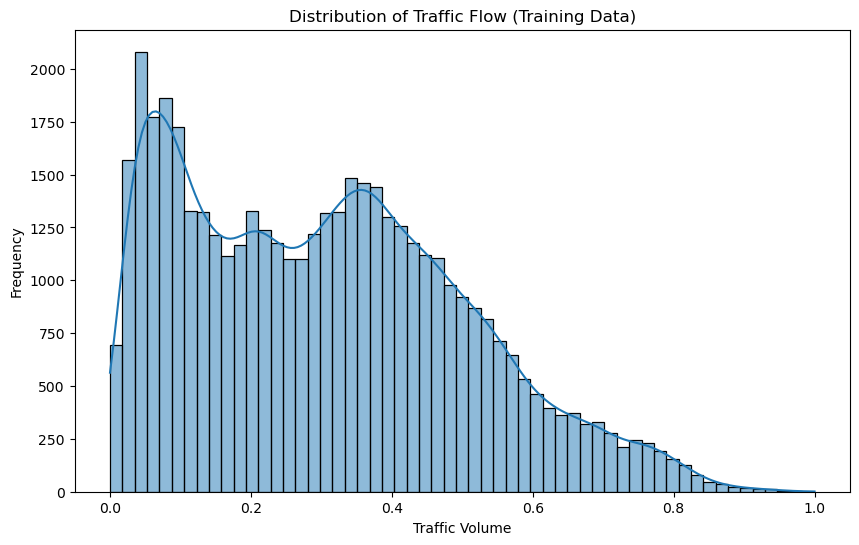

In [43]:
# Plotting the distribution of traffic flow
plt.figure(figsize=(10, 6))
sns.histplot(traffic_output_train.flatten(), kde=True)
plt.title('Distribution of Traffic Flow (Training Data)')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()


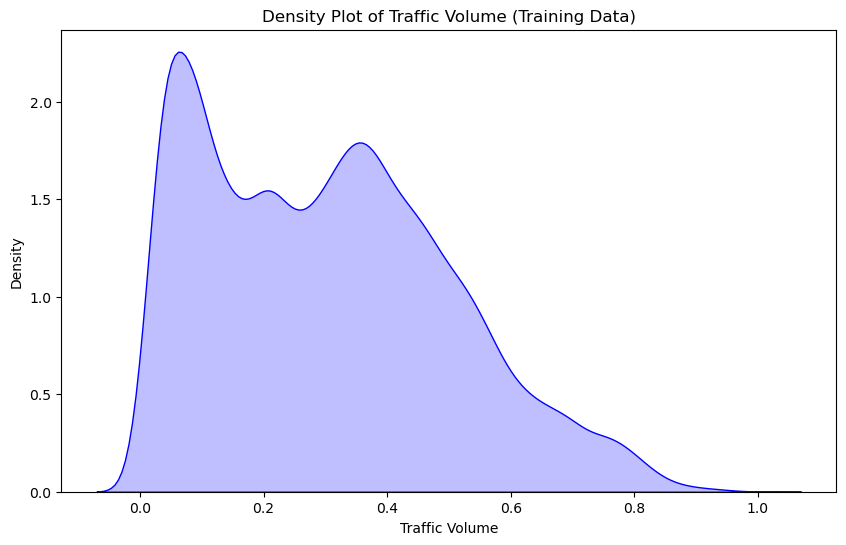

In [44]:
# Flatten the data
data_flat = traffic_output_train_df.values.flatten()

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data_flat, color='blue', fill=True)

plt.title('Density Plot of Traffic Volume (Training Data)')
plt.xlabel('Traffic Volume')
plt.ylabel('Density')
plt.show()



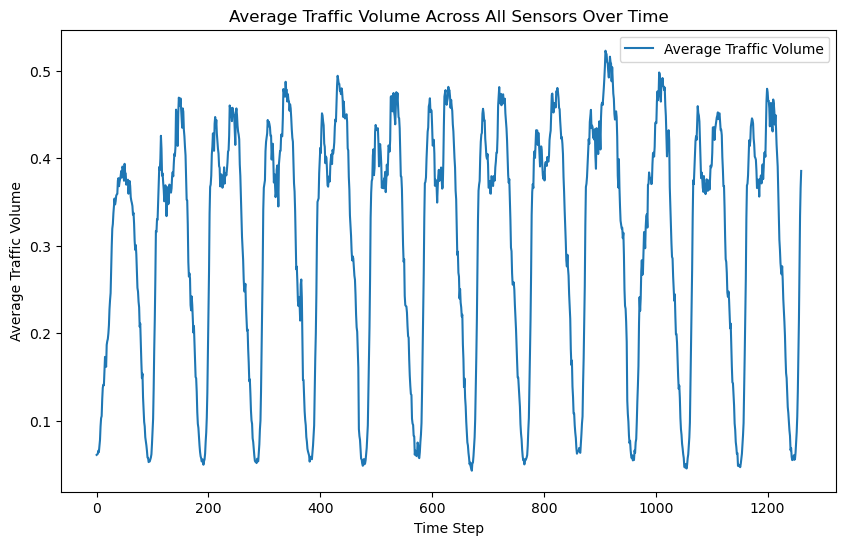

In [45]:
# Calculate the average traffic volume across all sensors for each time step
average_traffic_volume = traffic_output_train_df.mean(axis=0)

# Plot the average traffic volume over time
plt.figure(figsize=(10, 6))
plt.plot(average_traffic_volume, label='Average Traffic Volume')

plt.title('Average Traffic Volume Across All Sensors Over Time')
plt.xlabel('Time Step')
plt.ylabel('Average Traffic Volume')
plt.legend()
plt.show()


In [46]:
# Correlation matrix (optional)
# correlation_matrix = traffic_output_train_df.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix of Traffic Volumes')
# plt.show()


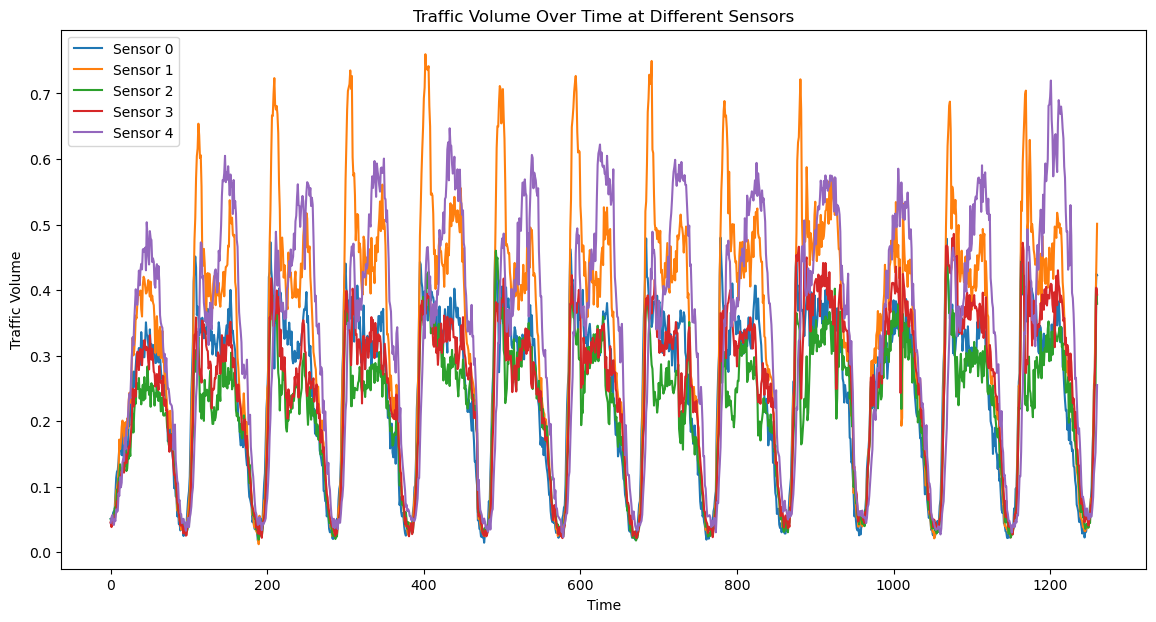

In [47]:
# Traffic volume over time at different sensors
plt.figure(figsize=(14, 7))
for i in range(5):  # Visualize first 5 sensors
    plt.plot(traffic_output_train_df.iloc[i, :], label=f'Sensor {i}')
plt.title('Traffic Volume Over Time at Different Sensors')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()



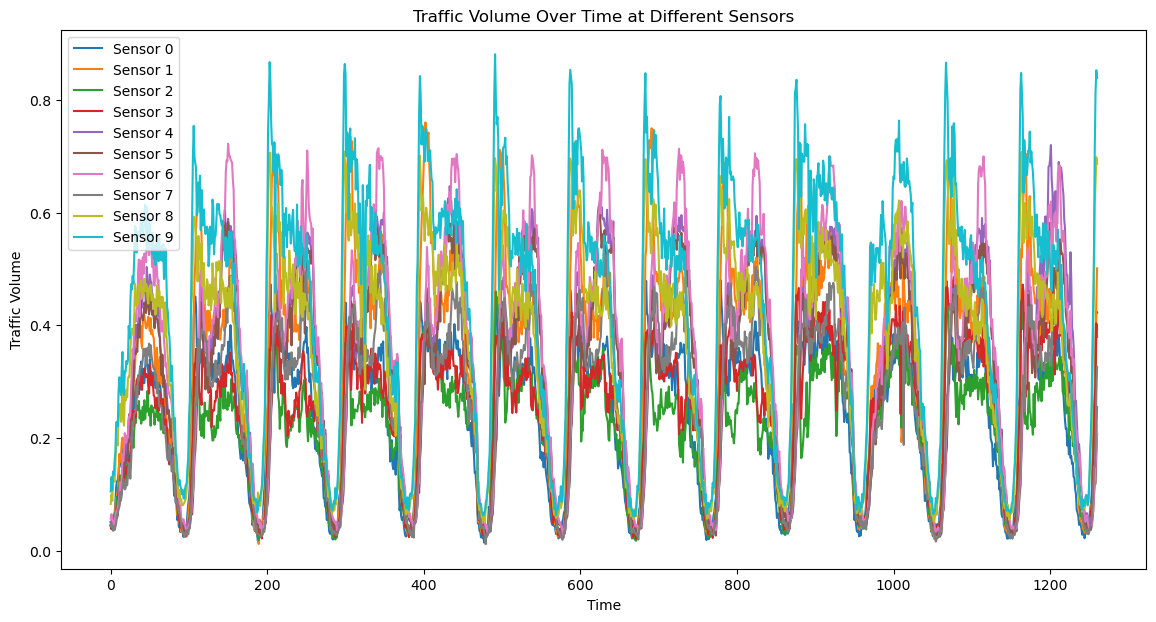

In [48]:
# Traffic volume over time at different sensors
plt.figure(figsize=(14, 7))
for i in range(10):  # Visualize first 5 sensors
    plt.plot(traffic_output_train_df.iloc[i, :], label=f'Sensor {i}')
plt.title('Traffic Volume Over Time at Different Sensors')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

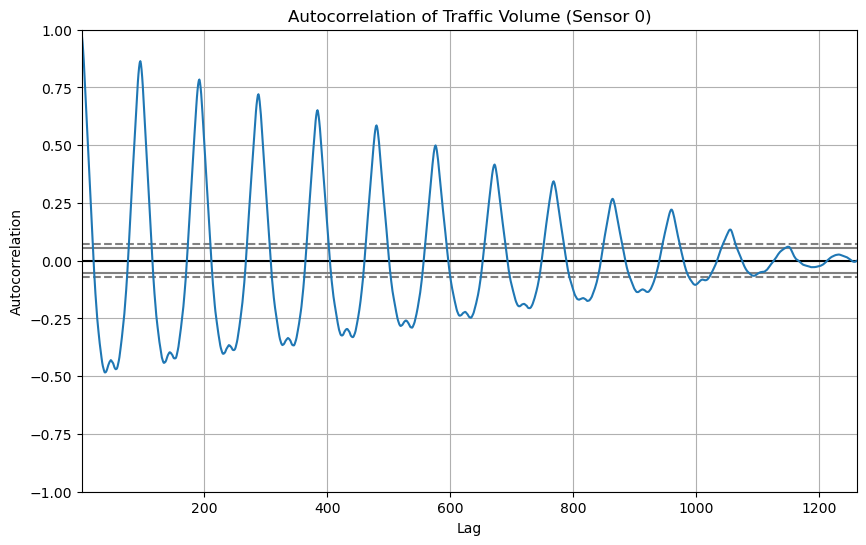

In [49]:
# Autocorrelation plot for the first sensor
plt.figure(figsize=(10, 6))
autocorrelation_plot(traffic_output_train_df.iloc[0, :])  # Autocorrelation for the first sensor
plt.title('Autocorrelation of Traffic Volume (Sensor 0)')
plt.show()

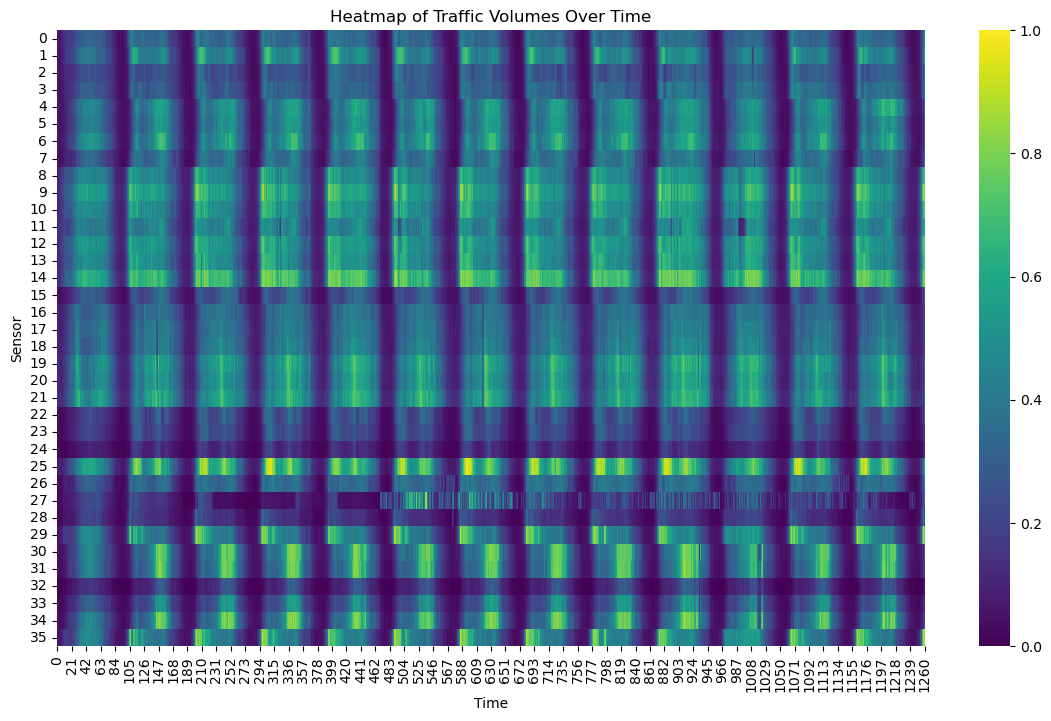

In [50]:
# Heatmap of traffic volumes over time
plt.figure(figsize=(14, 8))
sns.heatmap(traffic_output_train_df, cmap='viridis', cbar=True)
plt.title('Heatmap of Traffic Volumes Over Time')
plt.xlabel('Time')
plt.ylabel('Sensor')
plt.show()


## EDA Interpretation


## Preprocessing

We preprocess the data, preparing it for time series modeling. This includes flattening, scaling, and ensuring stationarity.

In [51]:
# Flattening the output for time series modeling
traffic_output_train_flat = traffic_output_train.flatten()
traffic_output_test_flat = traffic_output_test.flatten()


In [52]:
# Scaling the data using StandardScaler
scaler = StandardScaler()
traffic_output_train_scaled = scaler.fit_transform(traffic_output_train_flat.reshape(-1, 1))
traffic_output_test_scaled = scaler.transform(traffic_output_test_flat.reshape(-1, 1))



In [53]:
# Check for stationarity (using Augmented Dickey-Fuller test)
adf_result = adfuller(traffic_output_train_scaled)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')




ADF Statistic: -23.280265833229905
p-value: 0.0


The Augmented Dickey-Fuller (ADF) test revieled a negative statistic of -23.28 and p-value <.05. We reject the null hypothesis of non-stationarity. The traffic volume time series is stationary, meaning its statistical properties remain consistent over time, making it suitable for time series modeling without further transformation.

In [54]:
# If the series is not stationary, difference the series
#if adf_result[1] > 0.05:
#    diff_traffic_output_train = np.diff(traffic_output_train_scaled.flatten(), n=1)
#else:
#    diff_traffic_output_train = traffic_output_train_scaled.flatten()



## Data Validation

In [55]:
# Step: Data Validation

# Check the shape of the data
print("Shape of training data (scaled):", traffic_output_train_scaled.shape)
print("Shape of test data (scaled):", traffic_output_test_scaled.shape)

# Ensure the data type is correct (float, int, etc.)
print("\nData type of training data:", traffic_output_train_scaled.dtype)
print("Data type of test data:", traffic_output_test_scaled.dtype)

# Check for any NaN values in the dataset
print("\nNumber of NaN values in training data:", np.isnan(traffic_output_train_scaled).sum())
print("Number of NaN values in test data:", np.isnan(traffic_output_test_scaled).sum())

# Check a summary of the statistics to ensure scaling was done correctly
print("\nSummary statistics for the training data (scaled):")
print(pd.DataFrame(traffic_output_train_scaled).describe())




Shape of training data (scaled): (45396, 1)
Shape of test data (scaled): (30240, 1)

Data type of training data: float64
Data type of test data: float64

Number of NaN values in training data: 0
Number of NaN values in test data: 0

Summary statistics for the training data (scaled):
                  0
count  4.539600e+04
mean  -2.754770e-17
std    1.000011e+00
min   -1.524573e+00
25%   -8.903513e-01
50%   -5.486323e-02
75%    6.940336e-01
max    3.486015e+00


## Summary Statistics:
  - Data has been standardized with a mean close to 0 and a standard deviation of 1.
  - Ready for time series modeling.


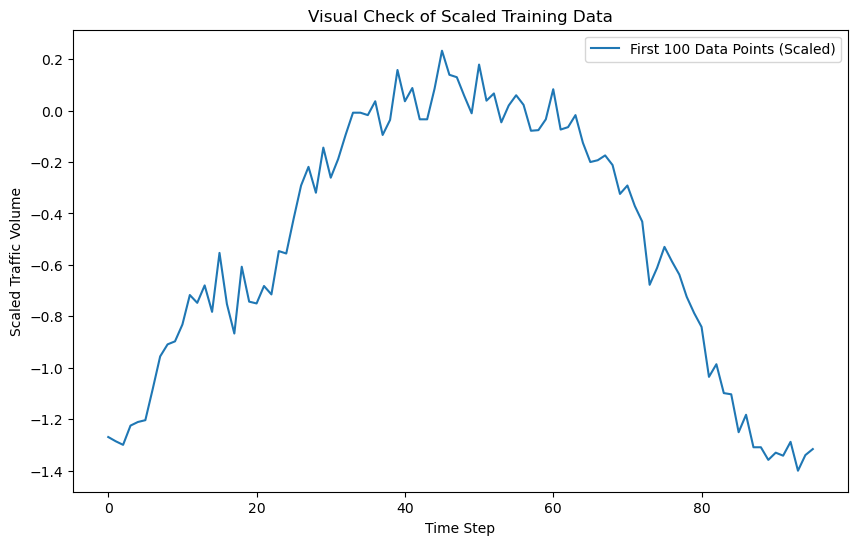

In [56]:
# confirm scaling
plt.figure(figsize=(10, 6))
plt.plot(traffic_output_train_scaled[:96], label='First 100 Data Points (Scaled)')
plt.title('Visual Check of Scaled Training Data')
plt.xlabel('Time Step')
plt.ylabel('Scaled Traffic Volume')
plt.legend()
plt.show()

## Model Training and Forecasting
Train model on the preprocessed data and use it to forecast future traffic volumes.

Each daily cycle appears to follow a Gaussian distribution.

In [57]:
# Simplified seasonal order
seasonal_order = (1, 0, 0, 96)

# Use a smaller subset of the data for quicker execution
sensor_data = pd.Series(traffic_output_train_scaled.flatten()[:5000])  # First 1000 data points

# Fit the simplified SARIMA model (ARIMA(p,d,q) with seasonal component)
model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Model summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 96)   Log Likelihood                2261.250
Date:                            Sun, 18 Aug 2024   AIC                          -4516.500
Time:                                    21:17:19   BIC                          -4496.949
Sample:                                         0   HQIC                         -4509.648
                                           - 5000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9614      0.004    221.916      0.000       0.953       0.970
ar.S.L96       0.3276      0.008   

In [58]:
# Seasonal order based on the identified cycle (daily cycles)
#seasonal_order = (1, 0, 0, 96)  # (p, d, q, s), where s=96 for daily seasonality

# Select the data for one sensor
#sensor_data = pd.Series(traffic_output_train_scaled.flatten())

# Fit the SARIMA model (ARIMA(p,d,q) with seasonal component)
#model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=seasonal_order)
#model_fit = model.fit()

In [59]:
# Model summary
#print(model_fit.summary())

In [60]:
try:
    model_fit
    print("model_fit exists.")
except NameError:
    print("model_fit does not exist. You may need to refit the model.")

try:
    sensor_data
    print("sensor_data exists.")
except NameError:
    print("sensor_data does not exist. You may need to reload the data.")


model_fit exists.
sensor_data exists.


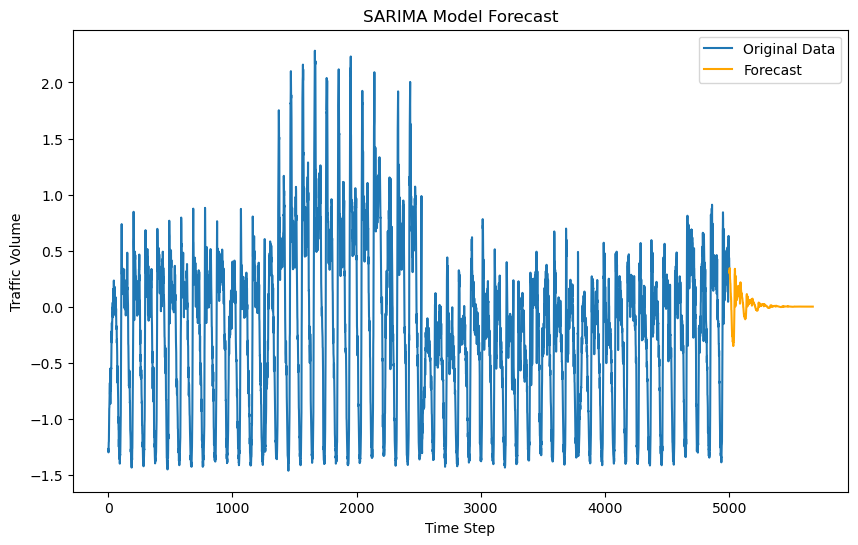

In [61]:
# Forecast the next 96*7 time steps (weeks worth)
forecast = model_fit.get_forecast(steps=96*7).predicted_mean

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(sensor_data, label='Original Data')
plt.plot(range(len(sensor_data), len(sensor_data) + 96*7), forecast, label='Forecast', color='orange')
plt.legend()
plt.title('SARIMA Model Forecast')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.show()


In [62]:
# Calculate the Mean Squared Error (MSE) between the forecast and actual values
val_data = traffic_output_test_flat[:len(forecast)]
mse = mean_squared_error(val_data, forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.07910279169138465


## Extending to more sensors


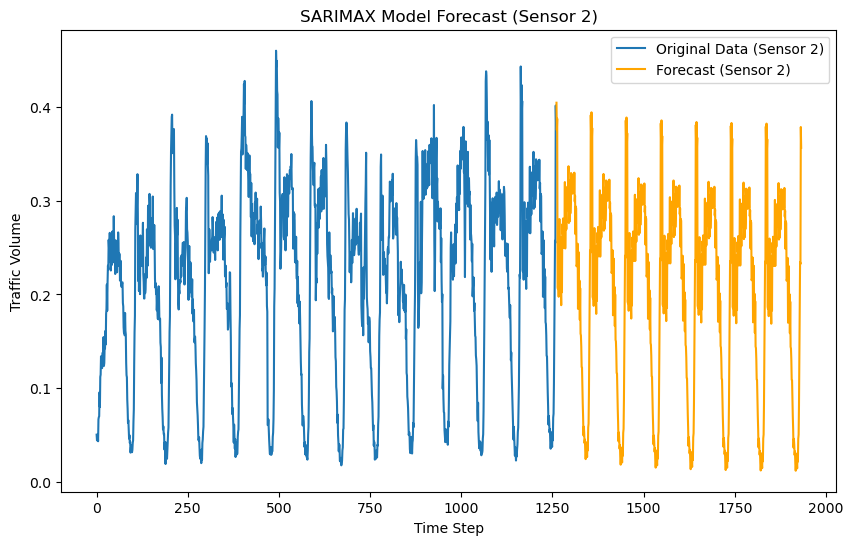

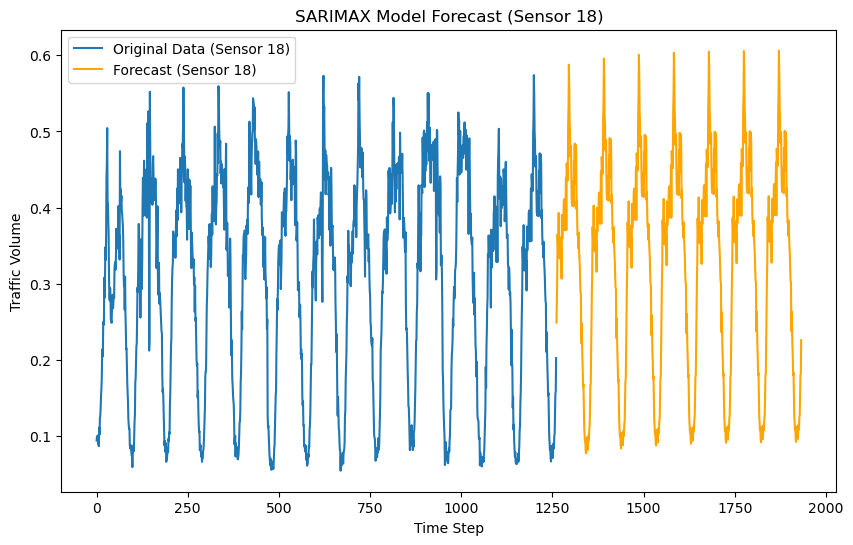

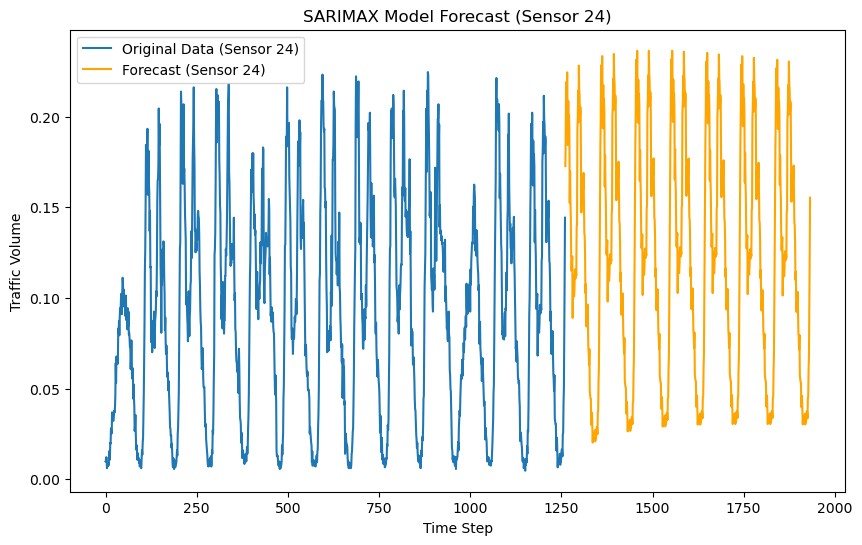

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the seasonal order for the SARIMAX model
seasonal_order = (1, 0, 0, 96)  # (p, d, q, s) with daily seasonality assumed

# Specify the indices of the sensors you want to model
specific_sensors = [2, 18, 24]

# Loop through the specific sensors' data
for sensor_index in specific_sensors:
    sensor_data = traffic_output_train_df.iloc[sensor_index, :].values

    # Fit the SARIMAX model
    model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast the next 96*7 time steps (one week)
    forecast = model_fit.get_forecast(steps=96*7).predicted_mean

    # Plot the original data and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(sensor_data, label=f'Original Data (Sensor {sensor_index})')
    plt.plot(range(len(sensor_data), len(sensor_data) + 96*7), forecast, label=f'Forecast (Sensor {sensor_index})', color='orange')
    plt.legend()
    plt.title(f'SARIMAX Model Forecast (Sensor {sensor_index})')
    plt.xlabel('Time Step')
    plt.ylabel('Traffic Volume')
    plt.show()


In [70]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#import matplotlib.pyplot as plt

# Define the seasonal order for the SARIMAX model
#seasonal_order = (1, 0, 0, 96)  # (p, d, q, s) with daily seasonality assumed


# Loop through each sensor's data
#for sensor_index in range(traffic_output_train_df.shape[0]):
#    sensor_data = traffic_output_train_df.iloc[sensor_index, :].values
#    
#    # Fit the SARIMAX model
#    model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=seasonal_order)
#    model_fit = model.fit(disp=False)
#    
#    # Forecast the next 96*7 time steps (one week)
#    forecast = model_fit.get_forecast(steps=96*7).predicted_mean
#    
#    # Plot the original data and the forecast
#    plt.figure(figsize=(10, 6))
 #   plt.plot(sensor_data, label=f'Original Data (Sensor {sensor_index})')
 #   plt.plot(range(len(sensor_data), len(sensor_data) + 96*7), forecast, label=f'Forecast (Sensor {sensor_index})', color='orange')
 #   plt.legend()
#    plt.title(f'SARIMAX Model Forecast (Sensor {sensor_index})')
#    plt.xlabel('Time Step')
#    plt.ylabel('Traffic Volume')
#    plt.show()



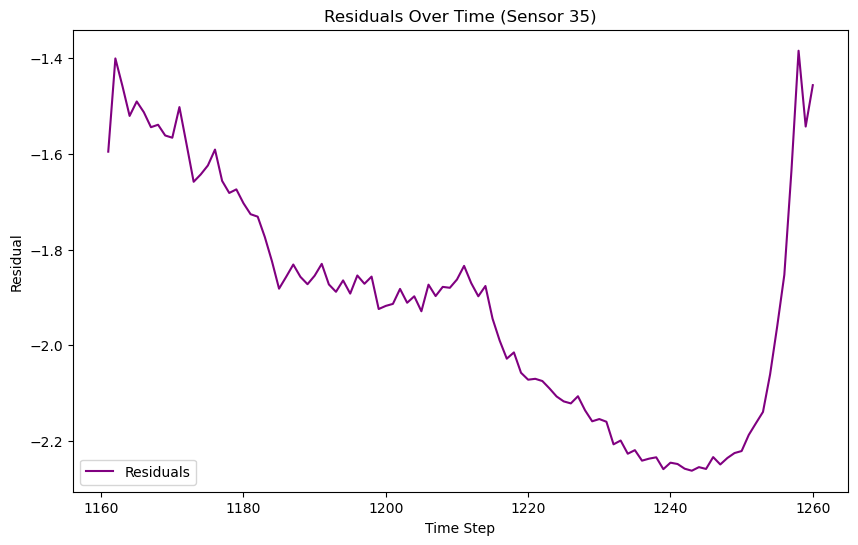

In [73]:
residuals = sensor_data[-len(forecast):] - forecast

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title(f'Residuals Over Time (Sensor {sensor_index})')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.legend()
plt.show()


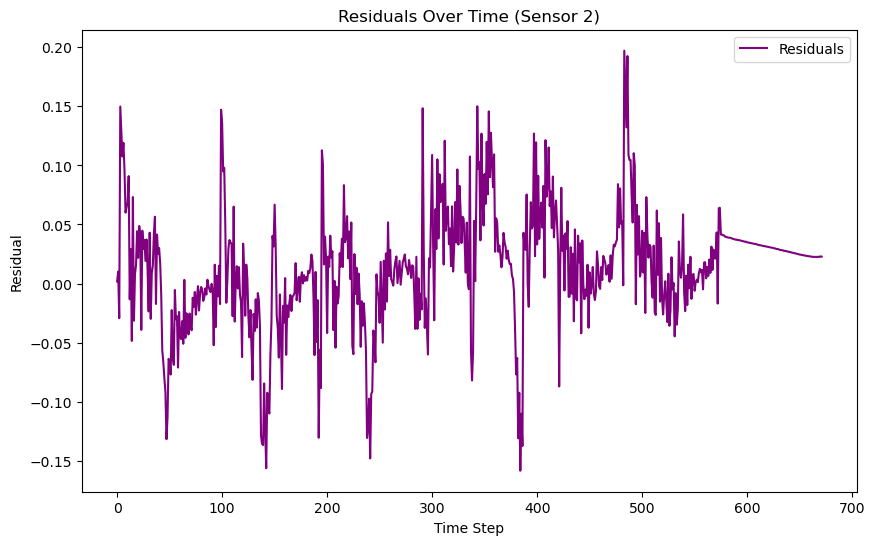

In [78]:
(sensor 2)
sensor_index = 2 

# Extract the data for the specific sensor
sensor_data = traffic_output_train_df.iloc[sensor_index, :].values

# Fit the SARIMAX model for this sensor
model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 96))
model_fit = model.fit(disp=False)

# Forecast the next 96*7 time steps (one week)
forecast = model_fit.get_forecast(steps=96*7).predicted_mean

# Calculate residuals
residuals = sensor_data[-len(forecast):] - forecast

# Plot residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title(f'Residuals Over Time (Sensor {sensor_index})')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.legend()
plt.show()


## Interpretation, Future Exploration/Improvements, and Conclusion... TBD

Fit well to a few of the sensors and not all of them.

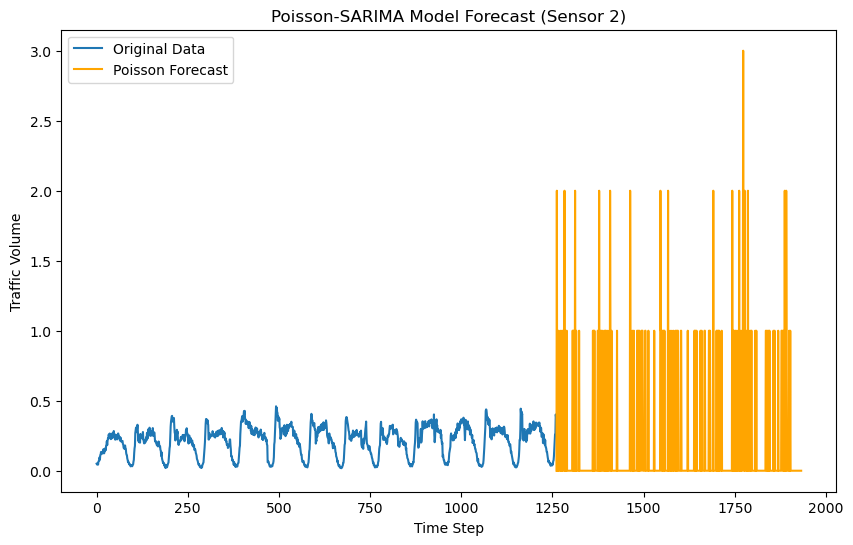

In [80]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming traffic_output_train_df is your DataFrame with traffic data for each sensor
sensor_index = 2  # example sensor index
sensor_data = traffic_output_train_df.iloc[sensor_index, :].values

# Estimate the average traffic volume (λ)
lambda_est = np.mean(sensor_data)

# Fit the SARIMA model (ARIMA(p,d,q) with seasonal component)
seasonal_order = (1, 0, 0, 96)  # Assuming daily seasonality with s=96
sarima_model = SARIMAX(sensor_data, order=(1, 0, 0), seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# Forecast the mean traffic count for the next 96*7 time steps (one week)
sarima_forecast = sarima_fit.get_forecast(steps=96*7).predicted_mean

# Simulate Poisson-distributed traffic counts using the SARIMA forecast as λ
poisson_forecast = poisson.rvs(mu=sarima_forecast)

# Plot the original data and the Poisson-distributed forecast
plt.figure(figsize=(10, 6))
plt.plot(sensor_data, label='Original Data')
plt.plot(range(len(sensor_data), len(sensor_data) + 96*7), poisson_forecast, label='Poisson Forecast', color='orange')
plt.legend()
plt.title(f'Poisson-SARIMA Model Forecast (Sensor {sensor_index})')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.show()


In [ ]:
# The Sarima model performs better accounting for seasonality...

In [23]:
# Select the data for one sensor
sensor_data = pd.Series(traffic_output_train_scaled.flatten())

# Fit the ARIMA model (ARIMA(p,d,q) where d=0 since the data is stationary)
model = ARIMA(sensor_data, order=(1, 0, 0))  # Adjust p and q
model_fit = model.fit()

# Model summary
print(model_fit.summary())




                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                45396
Model:                 ARIMA(1, 0, 0)   Log Likelihood                8479.594
Date:                Sun, 18 Aug 2024   AIC                         -16953.187
Time:                        21:01:29   BIC                         -16927.018
Sample:                             0   HQIC                        -16944.953
                              - 45396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.49e-13      0.055    4.5e-12      1.000      -0.109       0.109
ar.L1          0.9797      0.001    947.330      0.000       0.978       0.982
sigma2         0.0403   8.32e-05    484.562      0.0

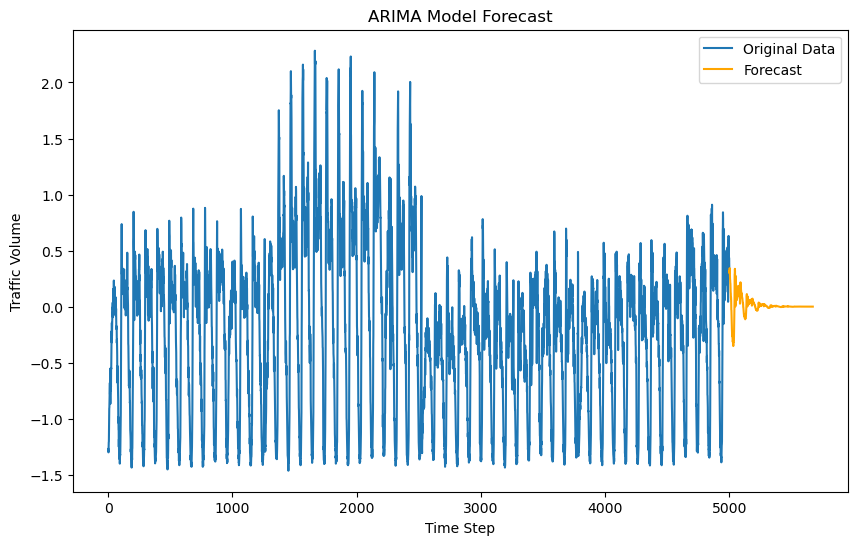

In [36]:
# Forecast the next 10 time steps
forecast = model_fit.forecast(steps=96*7)

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(sensor_data, label='Original Data')
plt.plot(range(len(sensor_data), len(sensor_data) + 96*7), forecast, label='Forecast', color='orange')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.show()



In [77]:
# Calculate the Mean Squared Error (MSE) between the forecast and actual values
val_data = traffic_output_test_flat[:len(forecast)]
mse = mean_squared_error(val_data, forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3.314981722184849


In [ ]:
# Ignore

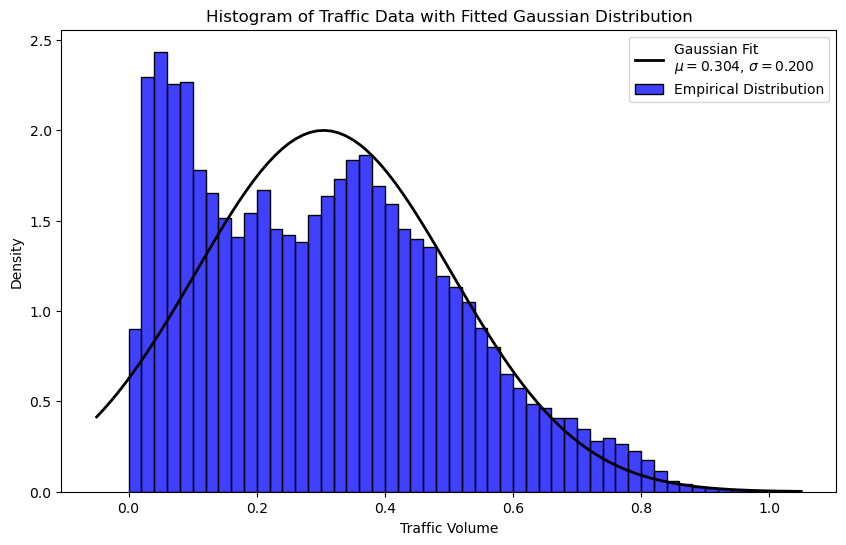

Kolmogorov-Smirnov test statistic: 0.06783372614256544
p-value: 4.57469757173607e-182
The data does not follow a Gaussian distribution (reject the null hypothesis).


In [80]:
from scipy.stats import norm, kstest

# Flatten the data for simplicity
data_flat = traffic_output_train.flatten()

# Fit a Gaussian distribution to the data
mu, std = norm.fit(data_flat)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
sns.histplot(data_flat, bins=50, kde=False, color='blue', stat='density', label='Empirical Distribution')

# Plot the PDF of the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian Fit\n$\mu={mu:.3f}$, $\sigma={std:.3f}$')

plt.title('Histogram of Traffic Data with Fitted Gaussian Distribution')
plt.xlabel('Traffic Volume')
plt.ylabel('Density')
plt.legend()
plt.show()

# Perform Kolmogorov-Smirnov test for normality
ks_statistic, p_value = kstest(data_flat, 'norm', args=(mu, std))
print(f"Kolmogorov-Smirnov test statistic: {ks_statistic}")
print(f"p-value: {p_value}")

# Interpretation
if p_value > 0.05:
    print("The data follows a Gaussian distribution (fail to reject the null hypothesis).")
else:
    print("The data does not follow a Gaussian distribution (reject the null hypothesis).")


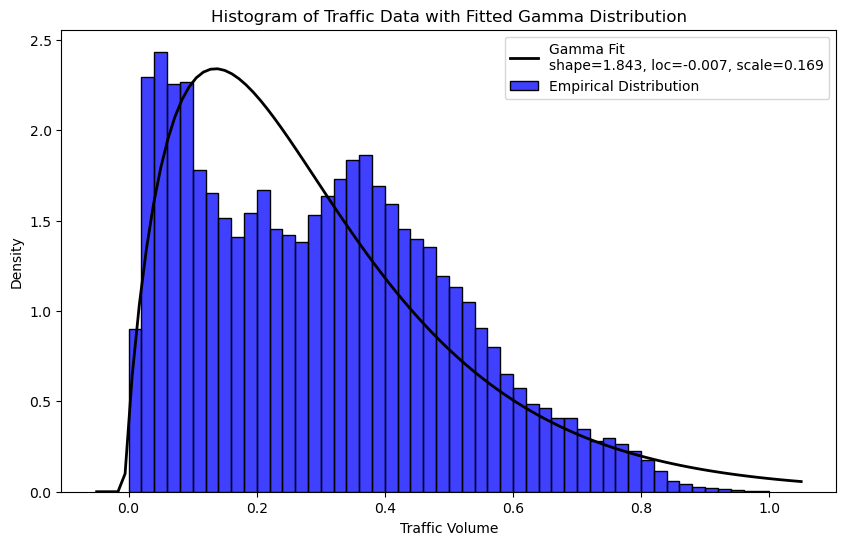

Kolmogorov-Smirnov test statistic: 0.082011227732809
p-value: 4.760734482477715e-266
The data does not follow a Gamma distribution (reject the null hypothesis).


In [36]:
from scipy.stats import gamma

# Fit a gamma distribution to the data
shape, loc, scale = gamma.fit(data_flat)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
sns.histplot(data_flat, bins=50, kde=False, color='blue', stat='density', label='Empirical Distribution')

# Plot the PDF of the fitted gamma distribution
p = gamma.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2, label=f'Gamma Fit\nshape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}')

plt.title('Histogram of Traffic Data with Fitted Gamma Distribution')
plt.xlabel('Traffic Volume')
plt.ylabel('Density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test for gamma distribution
ks_statistic, p_value = kstest(data_flat, 'gamma', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test statistic: {ks_statistic}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("The data follows a Gamma distribution (fail to reject the null hypothesis).")
else:
    print("The data does not follow a Gamma distribution (reject the null hypothesis).")


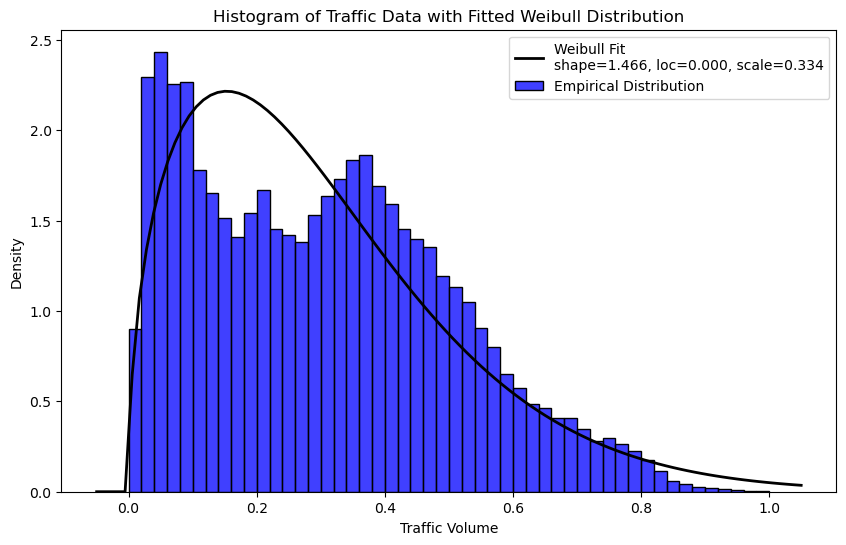

Kolmogorov-Smirnov test statistic: 0.06645940849472165
p-value: 8.968214806366403e-175
The data does not follow a Weibull distribution (reject the null hypothesis).


In [37]:
from scipy.stats import weibull_min

# Fit a Weibull distribution to the data
shape, loc, scale = weibull_min.fit(data_flat, floc=0)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
sns.histplot(data_flat, bins=50, kde=False, color='blue', stat='density', label='Empirical Distribution')

# Plot the PDF of the fitted Weibull distribution
p = weibull_min.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2, label=f'Weibull Fit\nshape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}')

plt.title('Histogram of Traffic Data with Fitted Weibull Distribution')
plt.xlabel('Traffic Volume')
plt.ylabel('Density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test for Weibull distribution
ks_statistic, p_value = kstest(data_flat, 'weibull_min', args=(shape, loc, scale))
print(f"Kolmogorov-Smirnov test statistic: {ks_statistic}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("The data follows a Weibull distribution (fail to reject the null hypothesis).")
else:
    print("The data does not follow a Weibull distribution (reject the null hypothesis).")
